<a href="https://colab.research.google.com/github/wiso/TutorialML-AtlasItalia2022/blob/main/notebooks/3.2-VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# preprocessing
train_images = train_images / 255.
test_images = test_images / 255.

# convert the numpy arrays to a tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

4431872/4422102 [==============================] - 0s 0us/step


In [38]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
base_depth = 32


class Autoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim, kl_weight=0.0001):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

        latent_dim_params = tfp.layers.MultivariateNormalTriL.params_size(latent_dim)
        self.encoder = tf.keras.Sequential([
            tfkl.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tfkl.Flatten(),
            tfkl.Dense(latent_dim_params, activation=None),
            tfpl.MultivariateNormalTriL(
                latent_dim,
                activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, weight=kl_weight)),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[latent_dim]),
            tf.keras.layers.Dense(7 * 7 * 64, activation='relu'),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='sigmoid'),

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 16 
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [39]:
history = autoencoder.fit(train_images, train_images,
                epochs=5,
                batch_size=512,
                validation_data=(test_images, test_images))

Epoch 1/5
118/118 [==============================] - 8s 52ms/step - loss: 0.0715 - val_loss: 0.0488
Epoch 2/5
118/118 [==============================] - 5s 45ms/step - loss: 0.0372 - val_loss: 0.0269
Epoch 3/5
118/118 [==============================] - 5s 46ms/step - loss: 0.0249 - val_loss: 0.0237
Epoch 4/5
118/118 [==============================] - 6s 48ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 5/5
118/118 [==============================] - 6s 49ms/step - loss: 0.0215 - val_loss: 0.0210


In [40]:
encoded_imgs = autoencoder.encoder(test_images)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

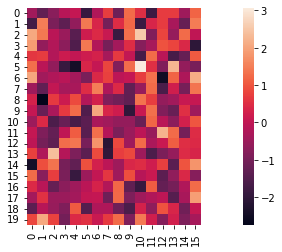

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(encoded_imgs[:20, :], ax=ax, square=True)
plt.show()

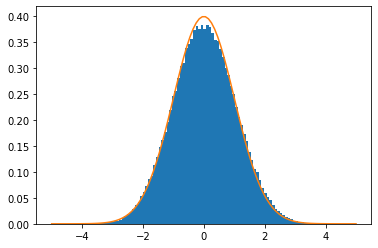

In [51]:
from scipy import stats

fig, ax = plt.subplots()
ax.hist(encoded_imgs.sample().numpy().flat, bins=100, density=True)
xspace = np.linspace(-5, 5, 100)
y = stats.norm(0, 1).pdf(xspace)
ax.plot(xspace, y)
plt.show()

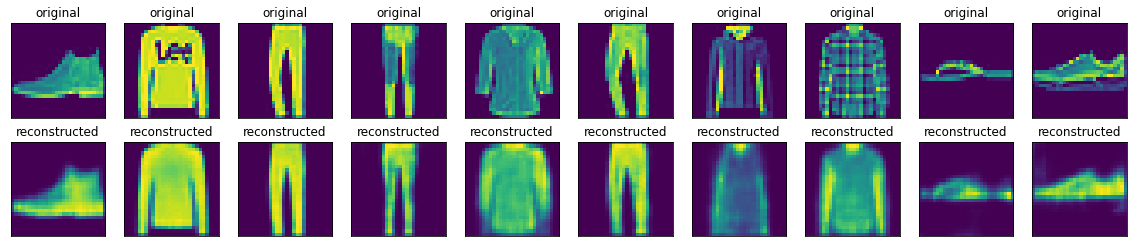

In [43]:
n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    ax = fig.add_subplot(2, n, i + 1)
    ax.imshow(test_images[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(2, n, i + 1 + n)
    ax.imshow(decoded_imgs[i, :, :, 0])
    ax.set_title("reconstructed")
    
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.show()

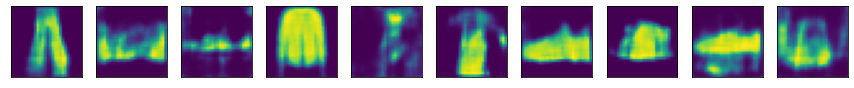

In [44]:
fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for ax in axs.flat:
    noise = np.random.multivariate_normal(np.zeros(latent_dim), np.eye(latent_dim))
    noise = np.expand_dims(noise, axis=0)
    decoded_img = autoencoder.decoder(noise).numpy()[0]
    ax.imshow(decoded_img[:, :, 0])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

In [45]:
np.random.multivariate_normal(np.zeros(latent_dim), np.eye(latent_dim))

array([ 0.33874828,  1.27870036, -0.40102212, -0.48599104, -2.18615346,
       -0.19922899,  0.76988564, -0.65271217, -0.11125964,  0.32081204,
       -1.60573393, -0.88050688, -0.33389777, -1.41740924, -0.02440878,
        0.40151889])

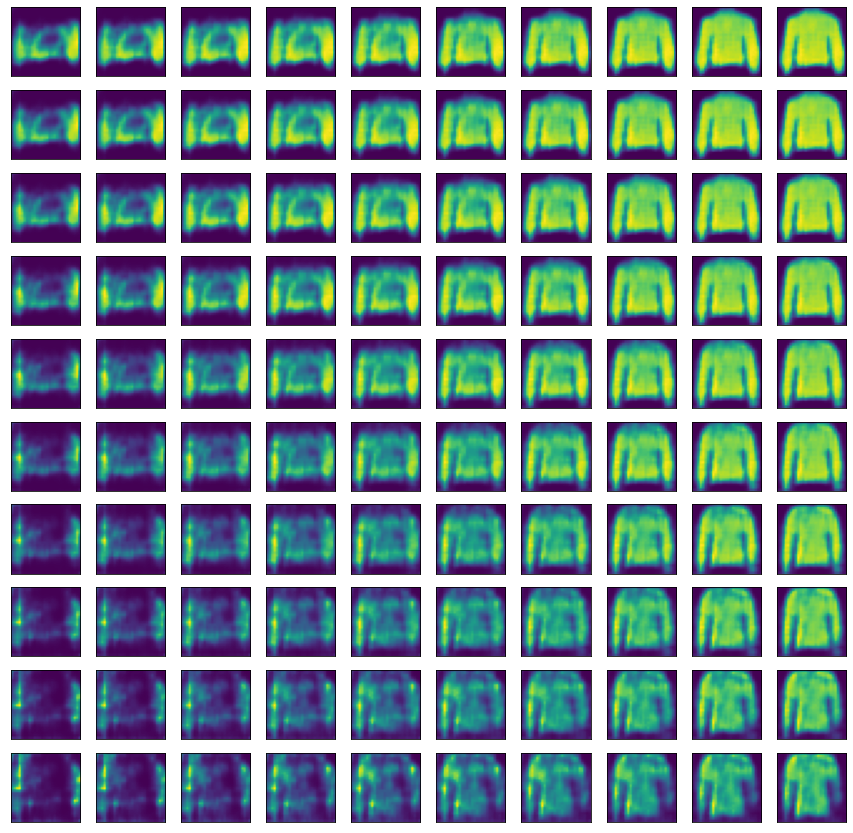

In [46]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
noise = np.random.multivariate_normal(np.zeros(latent_dim), np.eye(latent_dim))
for inoise1, noise1 in enumerate(np.linspace(-2, 2, 10)):
  for inoise2, noise2 in enumerate(np.linspace(-2, 2, 10)):
    noise[0] = noise1
    noise[1] = noise2
    decoded_img = autoencoder.decoder(np.expand_dims(noise, axis=0)).numpy()[0]
    axs[inoise1, inoise2].imshow(decoded_img[:, :, 0])

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
